In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import matplotlib
import tool
import sys
#!git clone https://github.com/fpesceKU/BLOCKING.git
sys.path.append('BLOCKING')
from main import BlockAnalysis

plt.rc('font', family='Arial')
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 9 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

cr = np.array([255,75,0])/255
cy = np.array([240,228,66])/255
cg = np.array([3,175,122])/255
cb = np.array([0,90,255])/255
cp = np.array([255,128,130])/255
co = np.array([246,170,0])/255
cv = np.array([153,0,153])/255

#軸設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛りの向き
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛りの向き
#plt.rcParams['axes.grid'] = True # グリッドの作成
#plt.rcParams['grid.linestyle']='--' #グリッドの線種
#plt.rcParams["xtick.minor.visible"] = True  #x軸補助目盛りの追加
#plt.rcParams["ytick.minor.visible"] = True  #y軸補助目盛りの追加
plt.rcParams['xtick.top'] = True  #x軸の上部目盛り
plt.rcParams['ytick.right'] = True  #y軸の右部目盛り

#凡例設定
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["legend.markerscale"] = 1 #markerサイズの倍率

In [2]:
def get_rg_sim(p,u,ion,_name,n,dir_):
    T,skip,unit = 293,100,1
    key=_name+"_p"+str(p)+"a"+str(u)+"u"+str(u)+"_"+str(ion)
    trj = md.load(dir_+"/{0}/{1}/{2}/{1}.dcd".format(key,_name,T),
              top=dir_+"/{0}/{1}/{2}/top.pdb".format(key,_name,T))
    masses = tool.get_mass(_name,n)
    rg = tool.calcRg(trj, masses=masses)[skip:]
    #print("p:{:d}, a{:d}, u{:d}, Ion{:d}".format(p,u,u,ion))
    #print(rg.shape)
    return np.array(rg)


def get_rg_by_lambda(l1,l2,ion,n_seq):
    rgs = []
    errs = []
    for n in n_seq:
        #name = 'polyU'+str(n)
        name = 'polyR'+str(n)
        dir_ = 'polyR'
        rg = get_rg_sim(l1,l2,ion,name,n,dir_)
        #print(rg)
        rgs.append(np.mean(rg))
        
        err =  get_blocking_error(l1,l2,ion,name,n,dir_)
        errs.append(err)
    return rgs, errs


def get_blocking_error(p,u,ion,_name,n,dir_):
    T,skip,unit = 293,500,1
    rg = get_rg_sim(p,u,ion,_name,n,dir_)
    block = BlockAnalysis(rg)    
    block.SEM()
    block_error =  block.sem             
    return block_error

def normal_eq(_x, _y):
    xTx = np.dot(_x.T, _x)
    xTx_inv = np.linalg.inv(xTx)
    w = np.dot(xTx_inv, np.dot(_x.T, _y))
    return w

def get_flory_exp(n_seq,rgs):
    xs = np.log(n_seq)
    bias = np.ones((len(xs)))
    xs = np.array([xs, bias]).T
    ys = np.log(rgs)
    w = normal_eq(xs, ys)
    
    r0 = np.exp(w[1])
    nu = w[0]
    return r0,nu

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


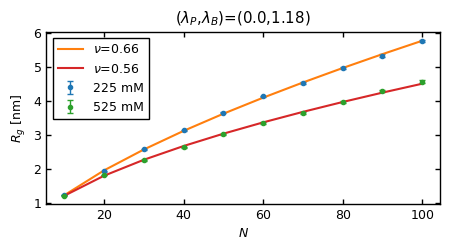

In [3]:
n_seq = [10,20,30,40,50,60,70,80,90,100]
ion=225
ls = [[0,118]]

a = 3.5
plt.figure(figsize=(16/a,9/a))
for ion in [225, 525]:
    for [l1,l2] in ls:
        rgs,errs = get_rg_by_lambda(l1,l2,ion,n_seq)
        plt.errorbar(n_seq,rgs,yerr=errs,label="{:d} mM".format(ion),marker='o', lw=0, ms=3, elinewidth=1, capsize=2, capthick=1)
        r0,nu = get_flory_exp(n_seq,rgs)
        xs = np.arange(10,110,10)
        plt.plot(n_seq,r0*(xs**nu),label="$\\nu$={:s}".format(str(nu)[:4]))
        

plt.legend()
plt.title('($\lambda_P$,$\lambda_B$)=({:s},{:s})'.format(str(l1/100)[:4],str(l2/100)[:4]))
plt.xlabel("$N$")
plt.ylabel("$R_g$ [nm]")
plt.tight_layout()
plt.savefig("fig.pdf",dpi=300)
#plt.yscale('log')
#plt.xscale('log')

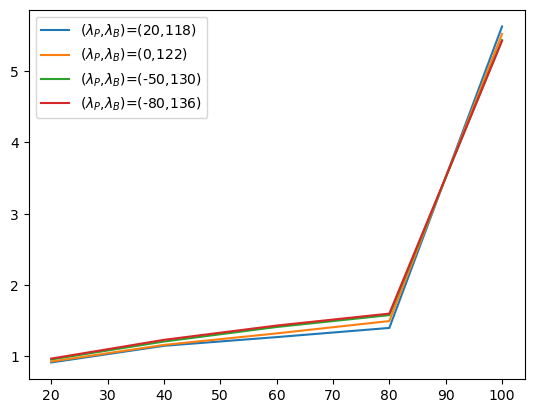

In [30]:
n_seq = [20,40,60,80,100]
ion=225
ls = [[20,118],[0,122],[-50,130],[-80,136]]

for [l1,l2] in ls:
    label='($\\lambda_P$,$\\lambda_B$)=({:d},{:d})'.format(l1,l2)
    rgs = get_rg_by_lambda(l1,l2,ion,n_seq)
    plt.plot(n_seq,rgs,label=label)
plt.legend()
#plt.yscale('log')
#plt.xscale('log')